稠密块体<br>
残差块将原值x和残差F(x)相加，<br>
稠密块将原值x和经过每次卷积块后的结果(输出通道不同), 按照通道维度进行连接


In [1]:
import torch
from torch import nn 
from d2l import torch as d2l 

def conv_block(input_channels, num_channels):
    """卷积块，即批量规范化层、激活层、卷积层"""
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )

In [ ]:
class DenseBlock(nn.Module):
    """稠密块体"""
    def __init__(self, num_convs, input_channels, num_channels):
        """ 
        Parameters
        -----------
            num_convs : 稠密块中卷积块个数
            input_channels : 输入通道数
            num_channels : 稠密块中每个卷积块的输出通道数 
        """
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels*i+input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个卷积块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

In [13]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

过渡层<br>
通过1x1卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高度和宽度，从而进一步降低模型复杂度

In [ ]:
def transition_block(input_channels, num_channels):
    """
    过渡层
    
    Parameters
    -----------
        input_channels : 输入通道数
        num_channels : 输出通道数
    """
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [15]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

DenseNet模型

In [16]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [17]:
# num_channels为当前的通道数, growth_rate稠密块中每个卷积层的输出通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]   # 4个稠密块，每个稠密块中各包括4个卷积层
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):  # 对每个稠密块，依次配置
    blks.append(DenseBlock(num_convs, num_channels, growth_rate)) # 稠密块
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate 
    # 在稠密块之间添加一个过渡层
    if i != len(num_convs_in_dense_blocks)-1:  # 不是最后一个稠密块
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [18]:
net = nn.Sequential(
    b1, *blks, 
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

训练模型

In [19]:
def try_xpu(i=0):
    """如果存在,则返回gpu(i),否则返回cpu()"""
    if torch.xpu.device_count() >= i+1:
        return torch.device(f'xpu:{i}')
    return torch.device('cpu')

loss 0.143, train acc 0.947, test acc 0.781
676.5 examples/sec on xpu:0


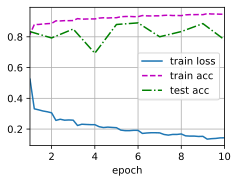

In [20]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, try_xpu())